In [2]:
# Librerías
import pandas as pd
import numpy as np
from pathlib import Path
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [3]:
sns.set_theme(style="darkgrid")

In [4]:
# Variables
src_path = os.getcwd()
data_path = "/data/raw/"
data_file = "merged_data.csv"

file_path= Path(os.path.dirname(src_path)+data_path+data_file)

In [5]:
df_coffee = pd.read_csv(file_path)

In [6]:
df_coffee.shape

(1339, 44)

In [7]:
df_coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1339 non-null   int64  
 1   Species                1339 non-null   object 
 2   Owner                  1332 non-null   object 
 3   Country.of.Origin      1338 non-null   object 
 4   Farm.Name              980 non-null    object 
 5   Lot.Number             276 non-null    object 
 6   Mill                   1021 non-null   object 
 7   ICO.Number             1180 non-null   object 
 8   Company                1130 non-null   object 
 9   Altitude               1113 non-null   object 
 10  Region                 1280 non-null   object 
 11  Producer               1107 non-null   object 
 12  Number.of.Bags         1339 non-null   int64  
 13  Bag.Weight             1339 non-null   object 
 14  In.Country.Partner     1339 non-null   object 
 15  Harv

<h2 style="text-align: center;">ANALIZANDO EL DATASET</h2>

El dataset consta de 1339 filas por 44 columnas y contiene la información relativa a diferentes variedades de café de tipo Arabica y Robusta calificadas por personal del CQI (Coffee Quality Institute).

La información se divide en:

Calidad de café (Cupping Score)
- Aroma
- Flavor
- Aftertaste
- Acidity
- Body
- Balance
- Uniformity
- Clean Cup
- Sweetness


Semilla (Bean)
- Species (arabica / robusta)
- Variety
- Processing Method
- Moisture
- Color
- Category.One.Defects
- Category.Two.Defects
- Quakers
- Expiration


Plantación (Farm)
- Country.of.Origin
- Harvest.Year
- Farm.Name
- Mill
- Owner
- Company
- Altitude + unit_of_measurement
- Region



La columna "Total Cup Points" será nuestro medidor de calidad, siendo mejor el café cuanto más alta sea esta puntuación.

Realizaremos un análisis univariante y multivariante de las información de la calidad y de la semilla junto con el país de origen, región, año de cosecha y altitud de la plantación con el objetivo final de encontrar un algoritmo que permita predecir qué café tendrá una mejor puntuación en función de todas sus características.

Para la información de la altitud, nos quedaremos con la columna "Altitude" y "altitude_mean_meters" que representa la media entre el valor máximo y mínimo de la altitud a la que se cultiva esa variedad de café en esa plantación. Además, necesitamos la columna "unit_of_measurement" para saber si la medida está en metros o pies.

<h2 style="text-align: center;">LIMPIEZA DEL DATASET</h2>

Borramos las columnas que no nos serán necesarias para la realización del análisis.

In [8]:
df = df_coffee.drop(columns=["Unnamed: 0", "Lot.Number", "ICO.Number", "Producer", "Number.of.Bags",
                             "Bag.Weight", "In.Country.Partner", "Grading.Date", "Cupper.Points",
                             "Certification.Body", "Certification.Address", "Certification.Contact",
                             "altitude_low_meters", "altitude_high_meters", "Owner.1", "Farm.Name",
                             "Mill", "Company", "Owner"])

<h3 style="text-align: center;">Chequeo de duplicados</h3>

In [9]:
# Cantidad de duplicados
df.duplicated().sum()

0

No hay registros duplicados.

<h3 style="text-align: center;">Chequeo de valores nulos</h3>

In [10]:
# Null / Missing values
df[df.columns[df.isnull().any()]].isnull().sum().sort_values(ascending=False)

Color                   270
altitude_mean_meters    230
Altitude                226
Variety                 226
Processing.Method       170
Region                   59
Harvest.Year             47
Country.of.Origin         1
Quakers                   1
dtype: int64

Hay bastante cantidad de valores nulos. Vamos a tratar de reducirlos todo lo posible.

<h4 style="text-align: center;"><ins>1 - Nulos en Region</ins></h4>

Saber la región en la que se cultiva un café puede ser importante para sus características.

Comprobamos si podemos inferir a qué región pertenece un café en función de su país de origen y la altitud media a la que se encuentra la plantación. La idea es que si uno de los registros nulos comparte altura y pais de origen con otro que que tenga un valor, supondremos que se trata de la misma región.

In [11]:
df.loc[(df["Region"].isnull()) & (df["Country.of.Origin"].notnull()), ["Country.of.Origin", "Region", 'altitude_mean_meters']]

,Country.of.Origin,Region,altitude_mean_meters
2,Guatemala,NaN,1700.0
5,Brazil,NaN,NaN
6,Peru,NaN,NaN
30,Nicaragua,NaN,NaN
31,"Tanzania, United Republic Of",NaN,NaN
100,Kenya,NaN,1.0
114,Kenya,NaN,NaN
134,Costa Rica,NaN,NaN
152,Kenya,NaN,NaN
223,Guatemala,NaN,NaN


La práctica totalidad de los registros con valor nulo en el campo de Región también presenta valor nulo para su altura media, con lo que es imposible imputar valores y por tanto decidimos eliminar estos registros.

In [12]:
df = df[df["Region"].notna()]

<h4 style="text-align: center;"><ins>2 - Nulos en altitud</ins></h4>


Uno de los valores que hemos considerado importante en el análisis es la altitud a la que se cultiva el café, por lo que es el primer dato que vamos a analizar 

1 - Comprobamos los valores de la columna "Altitud" que no son nulos junto con los de altitud media para tratar de imputar algún valor a esta última columna.

In [13]:
df.loc[(df["altitude_mean_meters"].isnull()) & df["Altitude"].notnull(), ["Altitude", "altitude_mean_meters"]]

,Altitude,altitude_mean_meters
169,mmm,NaN
170,test,NaN
687,huanuco,NaN
986,0,NaN


Con esos valores no podemos realizar ningún cálculo.

2 - Imputaremos los valores de altitud correspondientes a la media de la región a la que pertenecen.

In [14]:
df["altitude_mean_meters"].fillna(df.groupby(['Region'])['altitude_mean_meters'].transform('mean'), inplace=True)
print("Quedan {} valores nulos en la columna.". format(df["altitude_mean_meters"].isnull().sum()))

Quedan 22 valores nulos en la columna.


3 - Dado que aún quedan valores nulos, vamos a repetir el proceso pero imputando la moda de la altura con respecto al país. Decidimos no usar la media porque puede ocurrir que en un mismo país haya grandes diferencias en la altura en que sitúan las plantaciones y sería un valor que no coincide con los ya existentes.

In [15]:
df["altitude_mean_meters"].fillna(df.groupby(['Country.of.Origin'])['altitude_mean_meters'].transform(lambda x: x.mode()[0]), inplace=True)
print("Quedan {} valores nulos en la columna.". format(df["altitude_mean_meters"].isnull().sum()))

Quedan 0 valores nulos en la columna.


Hemos quitado todos los valores nulos de la altitud media, por lo que la columna Altitude se hace innecesaria en el conjunto de datos y procedemos a eliminarla.

In [16]:
df = df.drop(columns=["Altitude"])

<h4 style="text-align: center;"><ins>3 - Nulos en variedad</ins></h4>

Antes de estudiar los registros nulos comprobamos los diferentes tipos de variedad que hay en la tabla

In [17]:
df["Variety"].unique()

array([nan, 'Other', 'Catimor', 'Ethiopian Yirgacheffe', 'Caturra',
       'Bourbon', 'SL14', 'Sumatra', 'SL34', 'Hawaiian Kona',
       'Yellow Bourbon', 'SL28', 'Gesha', 'Catuai', 'Pacamara', 'Typica',
       'Sumatra Lintong', 'Mundo Novo', 'Java', 'Peaberry', 'Pacas',
       'Mandheling', 'Ruiru 11', 'Ethiopian Heirlooms', 'Moka Peaberry',
       'Arusha', 'Sulawesi', 'Blue Mountain', 'Marigojipe', 'Pache Comun'],
      dtype=object)

Dado que ya existe un valor genérico establecido como "Other" decidimos imputarles a todos los nulos ese valor genérico.

In [18]:
df["Variety"].fillna("Other", inplace = True)
print("Quedan {} valores nulos en la columna.". format(df["Variety"].isnull().sum()))

Quedan 0 valores nulos en la columna.


<h4 style="text-align: center;"><ins>4 - Nulos en Color</ins></h3>

Antes de estudiar los valores nulos, comprobamos los diferentes colores presentes en el dataset

In [19]:
df["Color"].unique()

array(['Green', nan, 'Bluish-Green', 'Blue-Green'], dtype=object)

El color de las semillas de café, antes del tostado, suele depender de la región en la que se hayan cultivado, por lo que en una primera fase imputaremos a los valores nulos el color más habitual en la región en la que son cultivados.

In [20]:
df["Color"].fillna(df.groupby(["Region"])["Color"].transform(lambda x: x.mode(dropna=False)[0]), inplace = True)
print("Quedan {} valores nulos en la columna.". format(df["Color"].isnull().sum()))

C:\Users\Sistemas\AppData\Local\Temp\ipykernel_21092\1264843671.py:1: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  df["Color"].fillna(df.groupby(["Region"])["Color"].transform(lambda x: x.mode(dropna=False)[0]), inplace = True)
C:\Users\Sistemas\AppData\Local\Temp\ipykernel_21092\1264843671.py:1: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  df["Color"].fillna(df.groupby(["Region"])["Color"].transform(lambda x: x.mode(dropna=False)[0]), inplace = True)


Quedan 157 valores nulos en la columna.


La imputación al color habitual de la región no ha sido de gran ayuda, por lo que repetiremos el proceso pero con la moda del color del país.

In [21]:
df["Color"].fillna(df.groupby(['Country.of.Origin'])['Color'].transform(lambda x: x.mode(dropna=False)[0]), inplace = True)
print("Quedan {} valores nulos en la columna.". format(df["Color"].isnull().sum()))

Quedan 62 valores nulos en la columna.


C:\Users\Sistemas\AppData\Local\Temp\ipykernel_21092\180732704.py:1: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  df["Color"].fillna(df.groupby(['Country.of.Origin'])['Color'].transform(lambda x: x.mode(dropna=False)[0]), inplace = True)


Dado que aún nos restan valores nulos y que existe una categoría que es "None" imputaremos a ese valor todos los nulos restantes

In [22]:
df["Color"].fillna("None", inplace=True)
print("Quedan {} valores nulos en la columna.". format(df["Color"].isnull().sum()))

Quedan 0 valores nulos en la columna.


<h4 style="text-align: center;"><ins>5 - Nulos en Método de procesado</ins></h3>

Como anteriormente, vamos a comprobar los tipos de métodos de procesado existentes en el dataframe.

In [23]:
df["Processing.Method"].unique()

array(['Washed / Wet', 'Natural / Dry', nan, 'Pulped natural / honey',
       'Semi-washed / Semi-pulped', 'Other'], dtype=object)

Dado que el método de procesado es difícil de imputar pues no tiene por qué seguir una lógica en función de la región o el país, vamos a imputar a todos los nulos el valor genérico "Other" que ya existe.

In [24]:
df["Processing.Method"].fillna("Other", inplace=True)
print("Quedan {} valores nulos en la columna.". format(df["Processing.Method"].isnull().sum()))

Quedan 0 valores nulos en la columna.


<h4 style="text-align: center;"><ins>6 - Nulos en Año de cosecha</ins></h3>

In [25]:
df["Harvest.Year"].unique()

array(['2014', 'March 2010', 'Sept 2009 - April 2010', 'May-August',
       '2009/2010', '2015', '2012', '2013', '2011', '2016', '2015/2016',
       '2010', 'Fall 2009', '2017', '2009 / 2010', '2010-2011', nan,
       '2009 - 2010', '2013/2014', '2017 / 2018', 'mmm', 'TEST',
       'December 2009-March 2010', '2014/2015', '2011/2012',
       'January 2011', '4T/10', '23 July 2010', 'January Through April',
       '1T/2011', '4t/2010', '4T/2010', 'August to December',
       'Mayo a Julio', '47/2010', 'Abril - Julio', '4t/2011', '2009-2010',
       'Abril - Julio /2011', 'Spring 2011 in Colombia.', '2016 / 2017',
       '3T/2011', '1t/2011', '2018', '4T72010', '08/09 crop'],
      dtype=object)

Viendo la cantidad de variabilidad que hay en la columna, decidimos extraer la última aparición de una cifra de 4 dígitos y tomarlos como el año de la cosecha. Almacenaremos el resultado en una nueva columna.

In [26]:
df["HarvestYear_Calc"] = df["Harvest.Year"].str.extract('(\d{4})(?!.*\d)')

Examinamos de nuevo los valores obtenidos tras la imputación.

In [27]:
df["HarvestYear_Calc"].unique()

array(['2014', '2010', nan, '2015', '2012', '2013', '2011', '2016',
       '2009', '2017', '2018'], dtype=object)

Nos quedan valores nulos, a los que imputaremos el valor genérico "unknown", pues para tratarlos deberíamos ir uno por uno.

In [28]:
df["HarvestYear_Calc"].fillna("UNKNOWN", inplace=True)
print("Quedan {} valores nulos en la columna.". format(df["HarvestYear_Calc"].isnull().sum()))

Quedan 0 valores nulos en la columna.


Ya no es necesaria la columna original del año de cosecha, por lo que podemos eliminarla

In [29]:
df.drop(columns=["Harvest.Year"], inplace=True)

<h4 style="text-align: center;"><ins>7 - Nulos en Quakers</ins></h3>

Los "Quakers" son aquéllas semillas de café que, por no estar maduras y por tanto no tener suficientes azúcares, no se caramelizan con el tostado y si no se retiran pueden provocar un empeoramiento de la calidad del café.

Esta columna indica el número de estas semillas encontradas en el saco de café.

In [30]:
df[df["Quakers"].isnull()]

,Species,Country.of.Origin,Region,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,...,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,unit_of_measurement,altitude_mean_meters,HarvestYear_Calc
366,Arabica,Colombia,huila,Caturra,Washed / Wet,7.58,7.67,7.58,7.75,7.58,...,83.5,0.11,0,NaN,Green,2,"May 24th, 2014",m,1750.0,2013


Como sólo tenemos un caso con un valor nulo y no podemos imputar ningún valor pues es una característica independiente a la región o al país, lo eliminaremos sin que afecte al desarrollo del análisis.

In [31]:
df = df[df["Quakers"].notna()]

---

Volvemos a comprobar los valores nulos, para asegurar que no nos queda ninguno.

In [32]:
# Null / Missing values
df[df.columns[df.isnull().any()]].isnull().sum().sort_values(ascending=False)

Series([], dtype: float64)

<h2 style="text-align: center;">ANÁLISIS DE VARIABLES</h2>

<h4 style="text-align: center;"><ins>1 - País de Origen</ins></h4>

Examinamos los valores únicos de la columna, por si fuera necesario realizar alguna codificación o traducción en sus valores.

In [33]:
df["Country.of.Origin"].unique()

array(['Ethiopia', 'United States', 'United States (Hawaii)', 'Indonesia',
       'China', 'Costa Rica', 'Mexico', 'Brazil', 'Uganda', 'Honduras',
       'Taiwan', 'Kenya', 'Thailand', 'Colombia', 'Guatemala', 'Panama',
       'Peru', 'Papua New Guinea', 'El Salvador',
       'Tanzania, United Republic Of', 'Nicaragua', 'Japan', 'Ecuador',
       'United States (Puerto Rico)', 'Haiti', 'Burundi', 'Vietnam',
       'Philippines', 'Rwanda', 'Malawi', 'Laos', 'Zambia', 'Myanmar',
       'Mauritius', 'Cote d?Ivoire', 'India'], dtype=object)

Los valores son relativamente pocos y no es necesario realizar ningún cambio.

<h4 style="text-align: center;"><ins>2 - Especie</ins></h4>

Examinanos las especies presentes en el dataset.

In [34]:
df["Species"].unique()

array(['Arabica', 'Robusta'], dtype=object)

Solamente hay dos especies y ningún registro carece de esta información.

<h4 style="text-align: center;"><ins>3 - Variedad</ins></h4>

Examinamos los tipos de variedad presentes en el conjunto de datos.

In [35]:
df["Variety"].unique()

array(['Other', 'Catimor', 'Ethiopian Yirgacheffe', 'Caturra', 'Bourbon',
       'SL14', 'Sumatra', 'SL34', 'Hawaiian Kona', 'Yellow Bourbon',
       'SL28', 'Gesha', 'Catuai', 'Pacamara', 'Typica', 'Sumatra Lintong',
       'Mundo Novo', 'Java', 'Peaberry', 'Pacas', 'Mandheling',
       'Ruiru 11', 'Ethiopian Heirlooms', 'Moka Peaberry', 'Arusha',
       'Sulawesi', 'Blue Mountain', 'Marigojipe', 'Pache Comun'],
      dtype=object)

Aunque son bastantes, no existe ningún valor extraño y todo aquéllo que no está definido tiene el valor genérico "Other"

<h4 style="text-align: center;"><ins>4 - Altitud</ins></h4>

Analizamos los valores de la columna relativa a la altitud media del cultivo. Dado que es un valor numérico, además del número de valores que presenta realizaremos un análisis de sus valores estadísticos.

In [36]:
df["altitude_mean_meters"].describe()

count      1279.000000
mean       1717.294785
std        8084.817357
min           1.000000
25%        1050.000000
50%        1310.640000
75%        1600.000000
max      190164.000000
Name: altitude_mean_meters, dtype: float64

Tener tanta variedad de alturas medias va a suponer un problema a la hora de analizar los datos y en el momento de las predicciones, por lo que se hace necesario realizar agrupamientos de valores a fin de simplificar esta categoría.

Además, podemos observar un valor máximo demasiado elevado que debemos tratar.

In [53]:
df[df["altitude_mean_meters"]>3000]

,Species,Country.of.Origin,Region,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,...,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,unit_of_measurement,altitude_mean_meters,HarvestYear_Calc,altitude_zscore
83,Arabica,Guatemala,oriente,Bourbon,Other,8.00,7.92,7.75,8.00,7.92,...,0.10,0,2.0,Green,2,"April 27th, 2017",m,4166.414642,2016,0.303047
215,Arabica,Guatemala,norte,Bourbon,Washed / Wet,7.58,7.83,7.58,7.83,7.83,...,0.10,0,0.0,Green,2,"June 1st, 2017",m,3280.000000,2016,0.193364
234,Arabica,Guatemala,oriente,Bourbon,Washed / Wet,8.00,7.75,7.50,7.58,7.92,...,0.10,0,0.0,Green,4,"April 27th, 2017",m,4166.414642,2016,0.303047
543,Arabica,Brazil,cerrado,Moka Peaberry,Semi-washed / Semi-pulped,7.08,7.50,7.50,7.83,7.75,...,0.11,0,0.0,Green,16,"August 15th, 2015",m,11000.000000,2015,1.148614
628,Arabica,Colombia,52 narino (exact location: mattituy; municipal...,Other,Other,7.33,7.58,7.42,7.42,7.67,...,0.11,0,0.0,Green,0,"November 15th, 2012",m,3850.000000,2011,0.263895
669,Arabica,Guatemala,oriente,Caturra,Natural / Dry,7.67,7.33,7.33,7.33,7.50,...,0.11,0,0.0,Green,5,"March 26th, 2013",m,4166.414642,2012,0.303047
837,Arabica,Guatemala,norte,Bourbon,Washed / Wet,7.58,7.50,7.33,7.42,7.58,...,0.10,2,0.0,Green,6,"August 2nd, 2017",m,3280.000000,2015,0.193364
840,Arabica,Myanmar,ywar ngan,Catuai,Washed / Wet,7.33,7.58,7.50,7.42,7.33,...,0.00,0,0.0,Green,2,"July 16th, 2016",m,4001.000000,2015,0.282579
875,Arabica,Nicaragua,jinotega,Other,Other,7.58,7.50,7.25,7.25,7.50,...,0.10,0,0.0,Green,1,"March 11th, 2017",m,10176.041667,UNKNOWN,1.046660
931,Arabica,Guatemala,oriente,Bourbon,Washed / Wet,7.33,7.50,7.33,7.42,7.17,...,0.11,0,0.0,Green,1,"January 24th, 2013",m,4166.414642,2012,0.303047


Para localizar los valores outliers en la columna, usaremos el valor de su zscore o número de desviaciones estándar de la media. Aquéllos con un valor superior a 3 serán considerados outliers.

In [49]:
df["altitude_zscore"]=np.abs(stats.zscore(df["altitude_mean_meters"]))
df.loc[df["altitude_zscore"]>2, ["altitude_mean_meters", "altitude_zscore"]]

,altitude_mean_meters,altitude_zscore
896,190164.0,23.317833
1040,110000.0,13.398579
1144,190164.0,23.317833


Dado que sólo hemos encontrado tres casos, decidimos eliminarlos.

In [51]:
df = df[df["altitude_zscore"]<3]

In [52]:
df["altitude_mean_meters"].describe()

count     1276.000000
mean      1337.062719
std        686.904998
min          1.000000
25%       1050.000000
50%       1310.640000
75%       1600.000000
max      11000.000000
Name: altitude_mean_meters, dtype: float64

Seguimos teniendo demasiados valores, por

---

<h4 style="text-align: center;"><ins>1 - País de Origen</ins></h4>

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df, y="Country.of.Origin", order= df["Country.of.Origin"].value_counts().index, ax=ax)
plt.show()

Los principales países productores de café presentes en el dataset son centroamericanos, con algunos africanos en posiciones centrales y los asiáticos con muy poca representación.

<h4 style="text-align: center;"><ins>2 - Especie</ins></h4>

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df, y="Species", order= df["Species"].value_counts().index, ax=ax)
plt.show()

El dataset está claramente poblado por más cantidad de registros de la especie "Arabica" que de la especie "Robusta".

Esto debe ser tenido en cuenta en el momento de la realización de predicciones, pues un desequilibrio tan grande afectará negativamente y ha de ser evitado.

<h4 style="text-align: center;"><ins>3 - Variedad</ins></h4>

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df, y="Variety", order= df["Variety"].value_counts().index, ax=ax)
plt.show()

La presencia de tantos registros sin un valor específico de la variedad de café cultivada nos afectará negativamente a la hora de predecir qué variedad es mejor, por lo que lo mejor sería no tener en cuenta este atributo en su momento, aunque vamos a mantenerlo durante el análisis.

<h4 style="text-align: center;"><ins>4 - Altitud</ins></h4>

In [ ]:
df["altitude_mean_meters"].agg(['min', 'max'])

min         1.0
max    190164.0
Name: altitude_mean_meters, dtype: float64

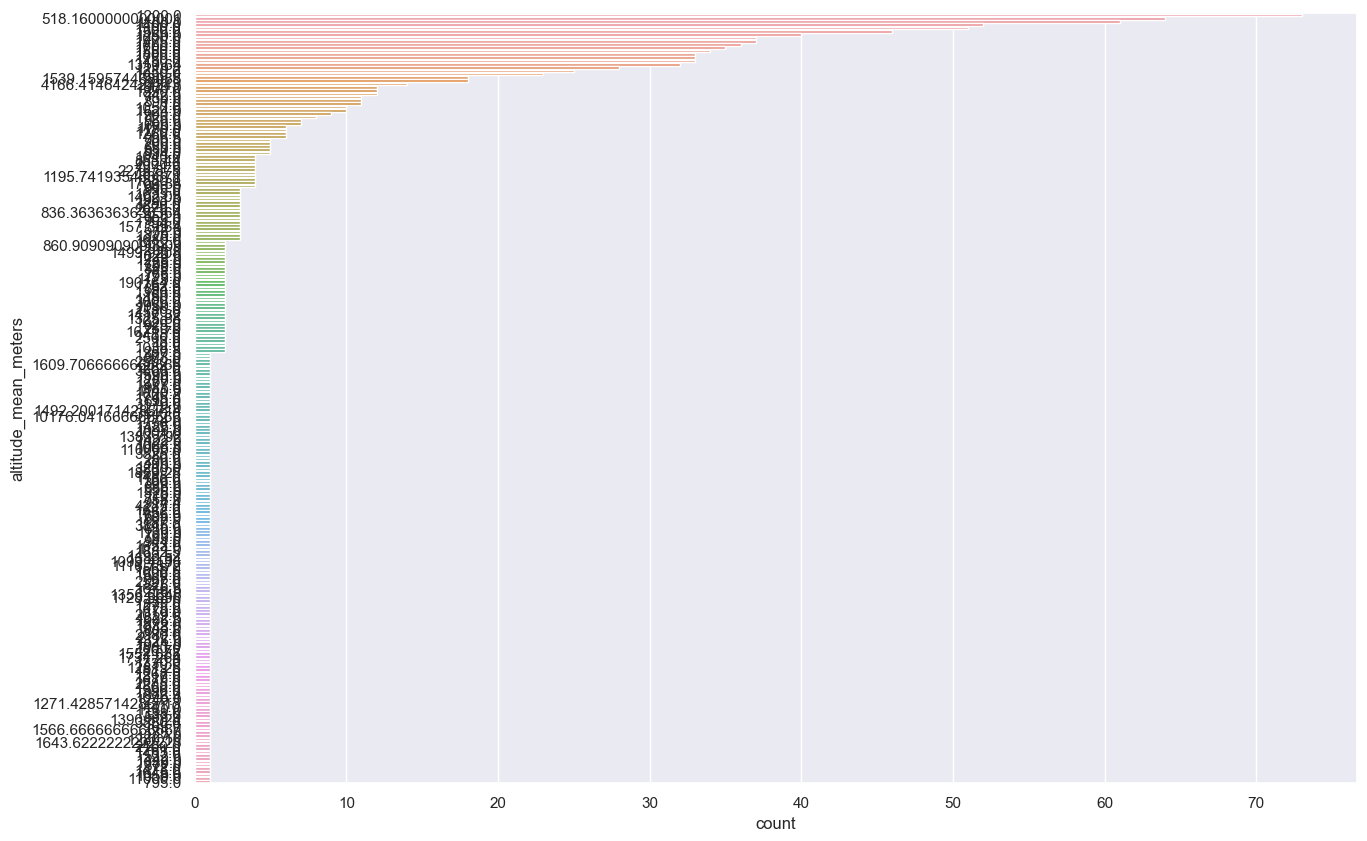

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df, y="altitude_mean_meters", order= df["altitude_mean_meters"].value_counts().index, ax=ax)
plt.show()

In [ ]:
<h4 style="text-align: center;"><ins>2 - Especie</ins></h4>

df.columns

Index(['Species', 'Country.of.Origin', 'Region', 'Variety',
       'Processing.Method', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
       'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Total.Cup.Points',
       'Moisture', 'Category.One.Defects', 'Quakers', 'Color',
       'Category.Two.Defects', 'Expiration', 'unit_of_measurement',
       'altitude_mean_meters', 'HarvestYear_Calc'],
      dtype='object')

#### Checking values for VARIETY

In [ ]:
df["Variety"].unique()

array(['Other', 'Catimor', 'Ethiopian Yirgacheffe', 'Caturra', 'Bourbon',
       'SL14', 'Sumatra', 'SL34', 'Hawaiian Kona', 'Yellow Bourbon',
       'SL28', 'Gesha', 'Catuai', 'Pacamara', 'Typica', 'Sumatra Lintong',
       'Mundo Novo', 'Java', 'Peaberry', 'Pacas', 'Mandheling',
       'Ruiru 11', 'Ethiopian Heirlooms', 'Moka Peaberry', 'Arusha',
       'Sulawesi', 'Blue Mountain', 'Marigojipe', 'Pache Comun'],
      dtype=object)

There are multiple and different values for unknown varieties or missing values. We will standarize it and assign the value "UNKNOWN" for all of them.

Also, we will replace the '+' symbols as well as 'and' or 'y' words with commas to correctly separate the coffee varieties.

To finish, we will write all the words in capital letters.

In [ ]:
df["Variety"][(df["Variety"]=='unknown') | (df["Variety"]=='unknow')] = "UNKNOWN"
df.loc[df["Variety"].str.contains(' \+ '), 'Variety'] = df["Variety"].str.replace(' + ',',')
df.loc[df["Variety"].str.contains('\+'), 'Variety'] = df["Variety"].str.replace('+',',')
df.loc[df["Variety"].str.contains(' and '), 'Variety'] = df["Variety"].str.replace(' and ',',')
df.loc[df["Variety"].str.contains(' Y '), 'Variety'] = df["Variety"].str.replace(' Y ',',')
df.loc[df["Variety"].str.contains(' & '), 'Variety'] = df["Variety"].str.replace(' & ',',')
df["Variety"] = df["Variety"].str.upper()


C:\Users\Sistemas\AppData\Local\Temp\ipykernel_4984\3628808133.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[df["Variety"].str.contains(' \+ '), 'Variety'] = df["Variety"].str.replace(' + ',',')
C:\Users\Sistemas\AppData\Local\Temp\ipykernel_4984\3628808133.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.loc[df["Variety"].str.contains('\+'), 'Variety'] = df["Variety"].str.replace('+',',')


#### Checking values for PROCESSING METHOD

In [ ]:
df["Processing Method"].unique()

KeyError: 'Processing Method'

We replace the method in spanish for the translated one, which is "Semi Washed" and set all values to capital letters

In [ ]:
df["Processing Method"][(df["Processing Method"]=='SEMI-LAVADO')] = 'Semi Washed'
df["Processing Method"] = df["Processing Method"].str.upper()